# HR Diagrams and Blackbody Curves
## Analysing the Local Galaxy - Part 2

In this notebook, I'm going to look at plotting a Hertzprung-Russell diagram of the local galaxy, as well as fitting blackbody curves to the stellar spectral data. 

As in part 1, we first need to import the data. 

In [1]:
import pandas as pd

datapath = 'Sim Data (Clusters; 800, Seed; 2639)' # all of the data is within a folder in this .ipynb file's directory
stardata = pd.read_csv(datapath + '/All Star Data.txt', delimiter=' ')    # read the data from the .txt file into a dataframe

equats = stardata['Equatorial']    # get the equatorial positions of all of the stars
polars = stardata['Polar']     # get the polar positions of all of the stars
parallax = stardata['Parallax']    # get the parallax of the stars

### Plotting a HR Diagram
We finished part 1 by finding the distribution of variable stars on a period-luminosity plot. 
Now, lets see if these variable stars belong to a certain point on a HR diagram. 

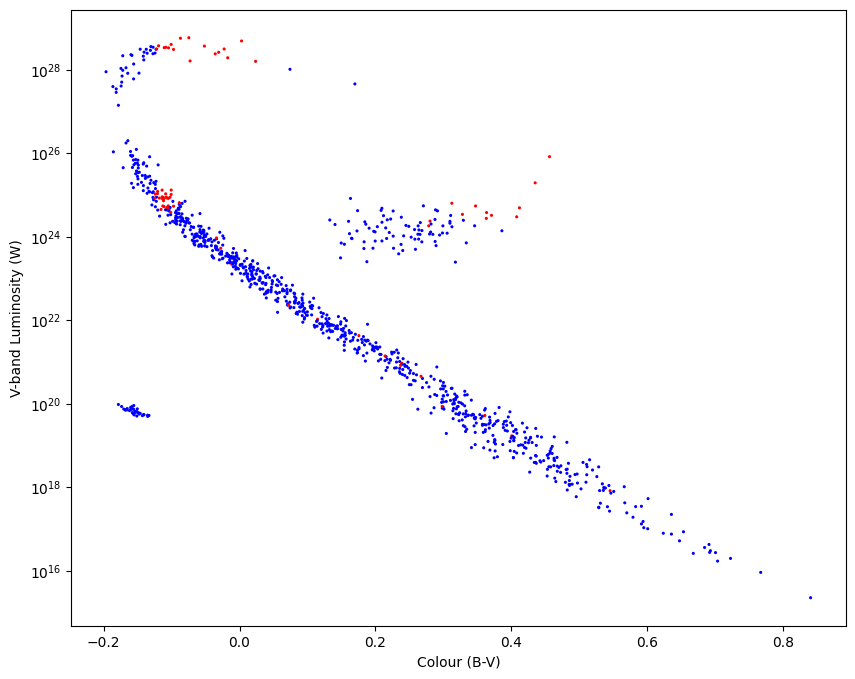

In [2]:
import numpy as np
import matplotlib.pyplot as plt

localindex = [i for i, x in enumerate(parallax) if x > 0.007]
localVflux = np.array(stardata["GreenF"])[localindex]
localBflux = np.array(stardata["BlueF"])[localindex]
BV = np.log10(localVflux / localBflux) # B-V colour index 

localVlumin = localVflux * (1 / np.array(stardata["Parallax"][localindex]) * 3.086 * 10**16)**2

localvariables = stardata["Variable?"][localindex]
colours = ['r' if var==1 else 'b' for var in localvariables] # this means variable stars are red, normal stars are blue

fig = plt.figure(figsize=(10, 8))   # make a figure to plot stuff on
ax = fig.add_subplot(1, 1, 1)    # and add an axis so we can plot stuff on the figure
ax.scatter(BV, localVlumin, s=1.5, c=colours)
ax.set_yscale('log'); ax.set_xlabel('Colour (B-V)'); ax.set_ylabel('V-band Luminosity (W)');

Excellent! We can clearly see that each class of variable star belongs to a certain position on a HR diagram. We can also see a whole host of features about stars in our local neighbourhood. One thing worth mentioning is that this is an *observational* HR diagram in that nothing has *really* been done to the values here, and so we can be pretty confident in the position of all of the stars. 

Finally, let's try to work out some stuff about the stars in our local galaxy. 

### Finding Star Temperatures
Maybe the most important metric (at least for now) about the stars is their temperatures. We can estimate the temperatures of stars with some curve-fitting magic of their wavelength data. Let's assume that these stars' spectra approximately fits a perfect blackbody spectrum. A really cool thing about temperature fitting is that we don't even need to know how far away the star is! We don't care about absolute luminosities, we only need the ratio of the band fluxes of the star. Pretty neat. 

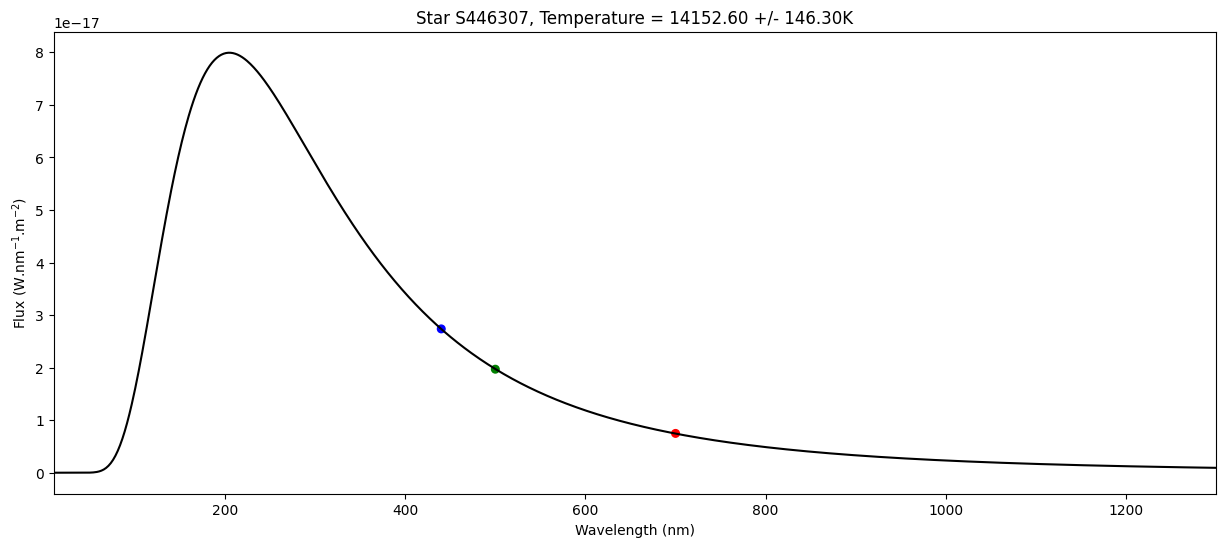

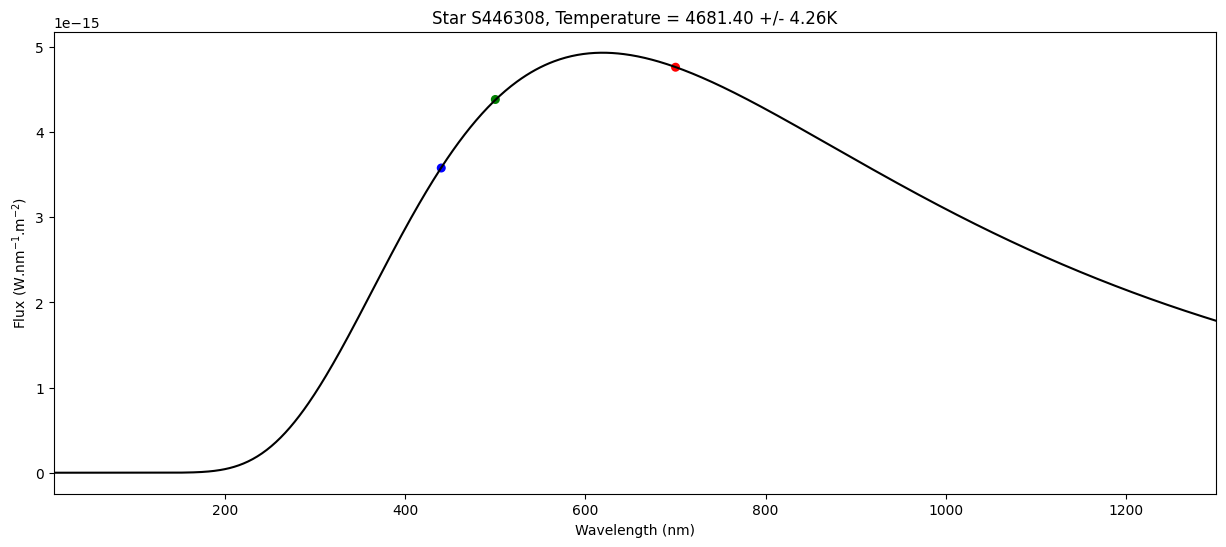

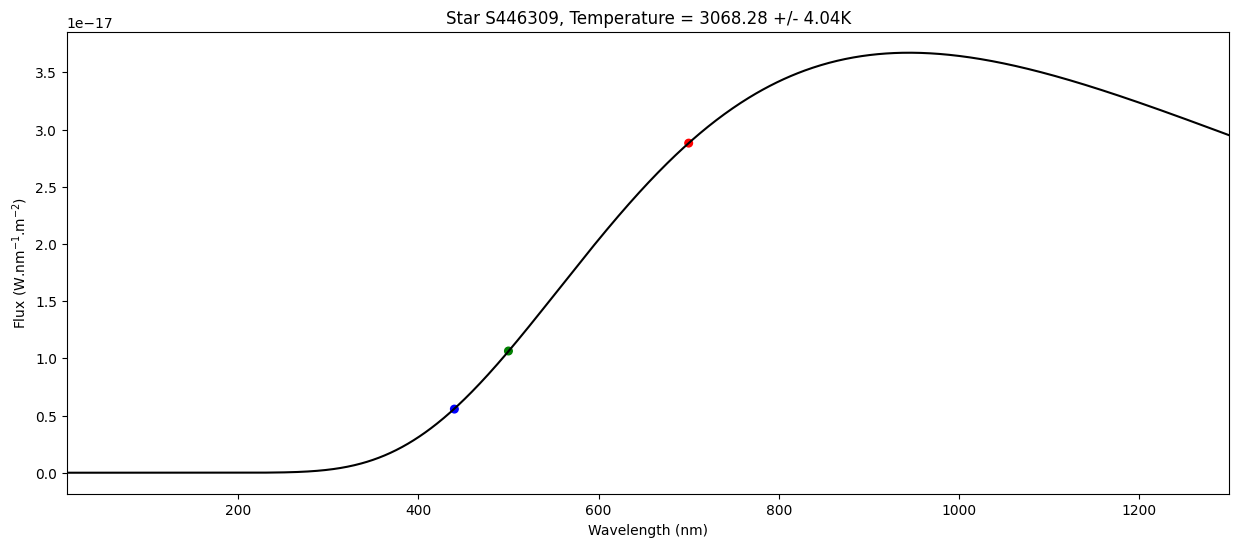

In [3]:
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')  # this code is going to give some RuntimeWarnings that I don't care about!

def planck_func(x, T, a):
    '''This is a planck function to be used with the scipy.optimize.curve_fit() function. 
    Parameters:
        x : float
            Wavelength in nm 
        T : float
            Temperature in K
        a : float
            a multiplier for the planck function
    '''
    const1 = 4.702 * 10**(-15)         #corresponds to 8 pi^2 * h * c^2
    const2 = 0.01439              #corresponds to h * c / k 
    funct = a * (const1 / (x * 10**-9)**5) * (1 / (np.exp(const2 / (x * 10**-9 * T)) - 1))
    return funct

# get the indices of stars in the local galaxy
closeindexes = [i for i, x in enumerate(parallax) if x > 0.007]

# now isolate each spectral band for each star
starBlue = stardata['BlueF']; starBlue = [starBlue[i] for i in closeindexes]
starGreen = stardata['GreenF']; starGreen = [starGreen[i] for i in closeindexes]
starRed = stardata['RedF']; starRed = [starRed[i] for i in closeindexes]
starnames = stardata["Name"]; starnames = [starnames[i] for i in closeindexes]

b, g, r = 440, 500, 700        #corresponding wavelengths for each luminosity measurement
wavelengths = np.array([b, g, r])
colours = ["b", "g", "r"]

localtemps = np.zeros(len(starBlue))

for i in range(len(starBlue)):
    fluxes = np.array([starBlue[i], starGreen[i], starRed[i]])
    
    starProps, params = curve_fit(planck_func, wavelengths, fluxes, p0=[10000, 1 * 10**-28], maxfev=10000)
    starTemp, mult = starProps
    localtemps[i] = starTemp
    
    # the curve_fit function gives a covariance matrix, where the square root of the top left element shows us the
    # uncertainty in our temperature measurement
    uncertainty = np.sqrt(np.diag(params))[0]
    
    x = np.linspace(10, 1300, 1000)
    planck = mult * (4.702 * 10**(-15) / (x * 10**-9)**5) * (1 / (np.exp(0.01439 / (x * 10**-9 * starTemp)) - 1))
    if i in [3, 4, 5]:    # I chose 3, 4, and 5 since they were nice and different curves
        # now to plot these blackbody curves
        fig = plt.figure(figsize=(15, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(x, planck, c='k', linewidth=1.5)
        ax.scatter(wavelengths, fluxes, c=colours, s=30)
        ax.set_xlim([min(x), max(x)])
        ax.set_xlabel('Wavelength (nm)'); ax.set_ylabel(r'Flux (W.nm$^{-1}$.m$^{-2}$)')
        ax.set_title('Star %s, Temperature = %.2f +/- %.2fK'%(starnames[i], starTemp, uncertainty))

These are some really good fits to the data! The uncertainties are extremely low compared to the actual values, and we love that. We can then proceed to do this for *every* star that we can see in the universe if we'd like, but that would be pretty computationally expensive so I won't do that here. I think it would be a good idea to take a look at the temperature distribution of stars in our galaxy next.

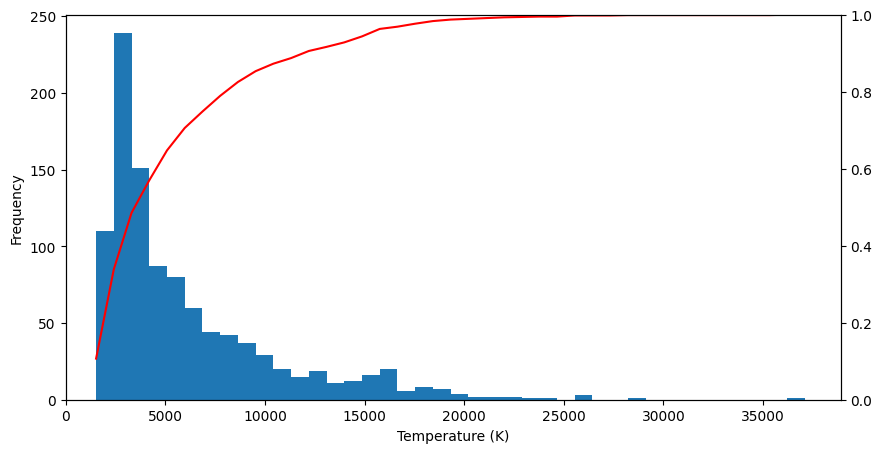

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
data = ax.hist(localtemps, bins=40)
ax.set_xlabel('Temperature (K)'); ax.set_ylabel('Frequency'); ax.set_xlim(xmin=0);

# lets also include a cumulative trendline
yvals, xbins, _ = data
cumulative = np.cumsum(yvals)
proportion = cumulative / sum(yvals)
ax2 = ax.twinx()
ax2.plot(xbins[:-1], proportion, 'r-')
ax2.set_ylim([0, 1]);

We can see that there aren't many _really_ low temperature stars, but there are **_lots_** of low-ish temperature stars. After about what looks like ~3500K, the frequency of star temperatures goes down more-or-less exponentially --- higher temperature stars are less common per temperature! 

Now, what does the HR diagram look like with temperature as the x-axis?

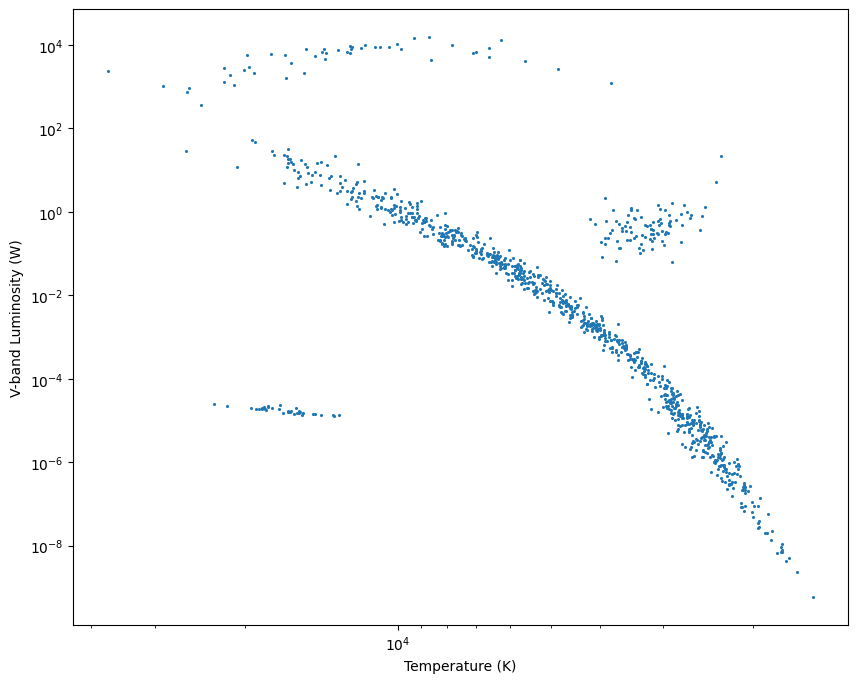

In [5]:
closeparallax = np.array([parallax[i] for i in closeindexes])
closeVlumin = starGreen * ((1 / closeparallax) * 3.086 * 10**16)**2

fig = plt.figure(figsize=(10, 8))   # make a figure to plot stuff on
ax = fig.add_subplot(1, 1, 1)    # and add an axis so we can plot stuff on the figure
ax.scatter(localtemps, closeVlumin / (3.84 * 10**24), s=1.5)
ax.set_yscale('log'); ax.set_xscale('log')
ax.set_xlabel('Temperature (K)'); ax.set_ylabel('V-band Luminosity (W)');
ax.invert_xaxis()

This looks really different to the HR diagram further up. Personally, I think this is a bit easier to interpret, but it is slightly less accurate since we can't be entirely sure about the values of each of the temperatures. In any case, it's impressive that we're able to work out this much so quickly!